## **Goal**

- Generate 1K test samples (quick iteration)
- Visual sanity check: does synthetic data look reasonable?

## **Success Criteria**
- CTGAN trains without errors
- Synthetic data has same columns as real data
- Fraud rate is somewhat preserved (~0.17%)
- Distributions roughly match 

---

## **1. Setup & Imports**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os 

import json
from pathlib import Path
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
from scipy.stats import ks_2samp
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## **2. Load Data & Baseline Stats**

In [2]:
# Load dataset
data_path = Path('../data/raw/creditcard.csv')  # Go up one level
df_real = pd.read_csv(data_path)

print(f"Real dataset shape: {df_real.shape}")
print(f"Fraud rate: {df_real['Class'].mean():.4f} ({df_real['Class'].sum()} frauds)")
print(f"\nColumns: {list(df_real.columns)}")

Real dataset shape: (284807, 31)
Fraud rate: 0.0017 (492 frauds)

Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [3]:
# Load baseline stats for later comparison
baseline_path = Path('../reports/eda/baseline_stats.json')
with open(baseline_path, 'r') as f:
    baseline_stats = json.load(f)


print(f"\nAvailable keys in baseline_stats:")
print(list(baseline_stats.keys()))

# Safely print counts based on what actually exists
if 'column_stats' in baseline_stats:
    print(f"  - {len(baseline_stats['column_stats'])} column profiles")
if 'ks_tests' in baseline_stats:
    print(f"  - {len(baseline_stats['ks_tests'])} KS test baselines")
if 'fraud_ks_tests' in baseline_stats:  # Maybe it's named this?
    print(f"  - {len(baseline_stats['fraud_ks_tests'])} fraud KS tests")
if 'v_correlations' in baseline_stats:
    print(f"  - {len(baseline_stats['v_correlations'])} V-feature correlations")


Available keys in baseline_stats:
['metadata', 'column_stats', 'correlations', 'ks_baselines', 'distribution_params']
  - 31 column profiles


## **3. Configure CTGAN Metadata**

SDV needs to understand our data structure before training.

In [4]:
# Auto-detect metadata from dataframe
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_real)

# Display detected metadata
print("Detected metadata:")
print(metadata)

Detected metadata:
{
    "columns": {
        "Time": {
            "sdtype": "numerical"
        },
        "V1": {
            "sdtype": "numerical"
        },
        "V2": {
            "sdtype": "numerical"
        },
        "V3": {
            "sdtype": "numerical"
        },
        "V4": {
            "sdtype": "numerical"
        },
        "V5": {
            "sdtype": "numerical"
        },
        "V6": {
            "sdtype": "numerical"
        },
        "V7": {
            "sdtype": "numerical"
        },
        "V8": {
            "sdtype": "numerical"
        },
        "V9": {
            "sdtype": "numerical"
        },
        "V10": {
            "sdtype": "numerical"
        },
        "V11": {
            "sdtype": "numerical"
        },
        "V12": {
            "sdtype": "numerical"
        },
        "V13": {
            "sdtype": "numerical"
        },
        "V14": {
            "sdtype": "numerical"
        },
        "V15": {
            "sdtype": "

In [5]:
# Optional: Manually specify column types if auto-detection is wrong
# (Usually not needed, but good to verify)

# Verify Time, Amount, Class are detected correctly
print("\nColumn types:")
for col in df_real.columns:
    sdtype = metadata.columns.get(col, {}).get('sdtype', 'unknown')
    print(f"  {col}: {sdtype}")


Column types:
  Time: numerical
  V1: numerical
  V2: numerical
  V3: numerical
  V4: numerical
  V5: numerical
  V6: numerical
  V7: numerical
  V8: numerical
  V9: numerical
  V10: numerical
  V11: numerical
  V12: numerical
  V13: numerical
  V14: numerical
  V15: numerical
  V16: numerical
  V17: numerical
  V18: numerical
  V19: numerical
  V20: numerical
  V21: numerical
  V22: numerical
  V23: numerical
  V24: numerical
  V25: numerical
  V26: numerical
  V27: numerical
  V28: numerical
  Amount: numerical
  Class: categorical


## **4. Train CTGAN (Simple First Pass)**

**Strategy for Day 3:**
- Start with **low epochs** (50) for quick feedback
- Use default hyperparameters
- See if it runs without crashing
- Check if fraud rate is somewhat preserved

**Expected time:** ~5-10 minutes on CPU

In [6]:
# Initialize CTGAN synthesizer with improved settings for Day 4
synthesizer = CTGANSynthesizer(
    metadata=metadata,
    epochs=150,  # Increased from 50
    verbose=True,
    enforce_min_max_values=True,  # Prevent impossible values
    enforce_rounding=False  # Keep continuous for now
)

print("✓ CTGAN synthesizer initialized (Day 4 settings)")
print(f"  - Epochs: {synthesizer.epochs}")
print(f"  - Batch size: {synthesizer.batch_size}")
print(f"  - Min/max enforcement: ON")

✓ CTGAN synthesizer initialized (Day 4 settings)
  - Epochs: 150
  - Batch size: 500
  - Min/max enforcement: ON


In [7]:
# Train CTGAN
print("Starting CTGAN training\n")
synthesizer.fit(df_real)


Starting CTGAN training



Gen. (-1.03) | Discrim. (-0.42): 100%|██████████| 150/150 [4:29:17<00:00, 107.72s/it]  


## **5. Generate Synthetic Samples**



In [8]:
# DAY 4: Generate with conditional Class preservation
# We'll tell CTGAN exactly how many frauds vs legit to make

n_samples = 10000  # Scaled up from 1K

# Calculate exact fraud count (preserving 0.173% rate)
n_fraud = int(n_samples * 0.00173)  # Should be ~17 frauds
n_legit = n_samples - n_fraud

print(f"Generating {n_samples} samples with preserved fraud rate:")
print(f"  - Legit (0): {n_legit}")
print(f"  - Fraud (1): {n_fraud}")
print(f"  - Expected rate: {n_fraud/n_samples:.4f} (0.173%)\n")

# Create conditional DataFrame
# This tells CTGAN: "Generate exactly this many of each class"
conditions = pd.DataFrame({
    'Class': [0]*n_legit + [1]*n_fraud
})

# Generate with conditions
df_synthetic = synthesizer.sample_remaining_columns(
    known_columns=conditions
)

print(f"\n✓ Generated {len(df_synthetic)} synthetic transactions")
print(f"Synthetic dataset shape: {df_synthetic.shape}")
print(f"Columns match real data: {list(df_synthetic.columns) == list(df_real.columns)}")

Generating 10000 samples with preserved fraud rate:
  - Legit (0): 9983
  - Fraud (1): 17
  - Expected rate: 0.0017 (0.173%)



Sampling remaining columns: 100%|██████████| 10000/10000 [00:03<00:00, 3010.47it/s]


✓ Generated 10000 synthetic transactions
Synthetic dataset shape: (10000, 31)
Columns match real data: True


In [9]:
# Quick peek at synthetic data
df_synthetic.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,153546.162567,0.121284,0.710380,-4.118203,-0.545483,1.879215,-0.636364,-0.513262,-0.269485,-2.497497,...,0.286569,0.661571,-0.171406,-0.356298,1.169778,-0.291483,-0.003672,0.030764,5.069461,0
1,50905.923556,1.152666,0.182329,0.579322,1.128591,-0.335696,-1.252927,-0.166393,0.292585,0.406125,...,0.081335,0.356194,0.118109,-0.398325,0.654002,0.109292,0.093782,0.088324,5.009250,0
2,104221.545125,0.116608,1.290672,0.615327,-0.101616,4.968312,0.645734,-0.811770,0.552892,-0.522000,...,0.221934,0.934758,0.072343,0.643524,-0.512926,0.693674,0.129346,0.032256,3.550668,0
3,42919.875420,-0.495869,0.207658,0.311160,-1.082316,-1.768769,-0.060403,0.012563,0.375436,1.047254,...,-0.146435,-1.585323,0.260537,0.052202,0.541556,0.595899,0.767755,0.231208,73.994782,0
4,45714.359150,1.190337,-0.642422,0.387473,-0.326838,-0.893436,-0.814248,-0.534694,-1.012975,-0.049647,...,0.208569,-0.165033,-0.165672,-0.484767,0.527819,-0.179738,0.371695,0.269874,6.260927,0
5,160202.606753,0.434326,0.208719,0.029245,-0.602102,1.276783,-1.338258,0.552951,-0.570861,-0.131859,...,0.006745,0.129302,0.399267,-0.110504,-0.521112,-0.413391,0.089657,0.055251,16.417096,0
6,50797.842348,-1.604894,1.204303,1.448677,0.760175,0.252996,1.441341,0.781283,-0.211743,-0.741569,...,-0.569176,-0.882232,-0.090794,-1.316120,0.003109,-1.078568,0.258231,0.208829,32.829736,0
7,131562.284911,-0.238601,0.011532,-0.445207,-0.477213,1.568427,-1.196230,0.058530,-0.691847,-0.691207,...,-0.131228,-1.266294,-0.497417,0.916710,-0.311047,-0.545703,-0.007693,-0.038763,3.676196,0
8,84062.127369,-2.471082,-1.089069,1.662345,-2.659285,-0.157727,-0.408789,0.205583,0.178747,1.427493,...,0.514932,-0.062193,0.047694,-0.349543,0.417512,0.565280,-0.015201,-0.034495,443.016189,0
9,55771.208125,-9.286275,-3.408732,1.312178,-0.922781,5.192360,0.933031,-1.315034,-0.156173,-0.824732,...,0.355713,0.609252,-1.352208,-0.695907,0.482090,-0.226945,1.858745,0.288149,31.163517,0


In [10]:
# Verify the conditional generation worked
synthetic_fraud_rate = df_synthetic['Class'].mean()
real_fraud_rate = df_real['Class'].mean()

print("CONDITIONAL GENERATION VERIFICATION")
print(f"Target fraud count: {n_fraud}")
print(f"Actual fraud count: {df_synthetic['Class'].sum():.0f}")
print(f"Target fraud rate: 0.0017 (0.17%)")
print(f"Actual fraud rate: {synthetic_fraud_rate:.4f} ({synthetic_fraud_rate*100:.2f}%)")
print(f"\n✅ Class distribution FORCED by conditional sampling")

CONDITIONAL GENERATION VERIFICATION
Target fraud count: 17
Actual fraud count: 17
Target fraud rate: 0.0017 (0.17%)
Actual fraud rate: 0.0017 (0.17%)

✅ Class distribution FORCED by conditional sampling


## **6. First Visual Check: Class Distribution**

**Critical check:** Is the fraud rate preserved?

FRAUD RATE COMPARISON
Real:      0.0017 (0.17%)
Synthetic: 0.0017 (0.17%)
Difference: 0.0000


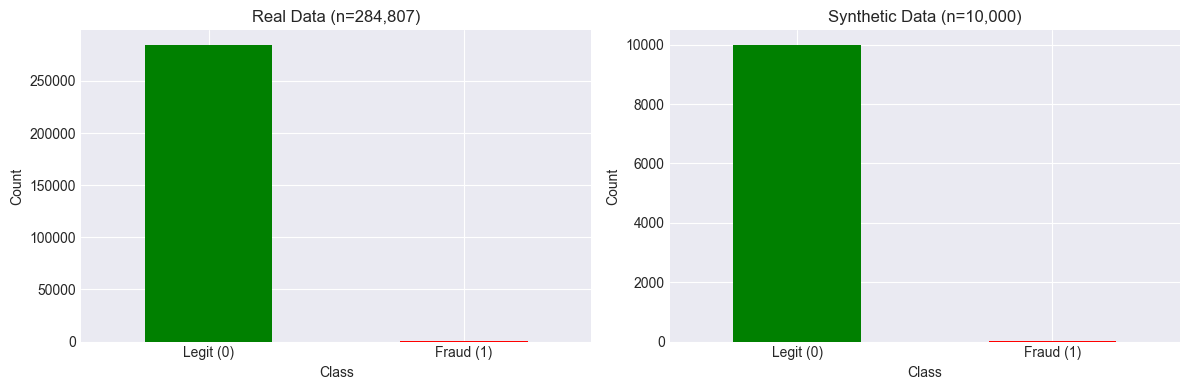


Real Class dtype: int64
Synthetic Class dtype: int64


In [11]:
# Compare fraud rates
real_fraud_rate = df_real['Class'].mean()
synthetic_fraud_rate = df_synthetic['Class'].mean()

print("FRAUD RATE COMPARISON")
print(f"Real:      {real_fraud_rate:.4f} ({real_fraud_rate*100:.2f}%)")
print(f"Synthetic: {synthetic_fraud_rate:.4f} ({synthetic_fraud_rate*100:.2f}%)")
print(f"Difference: {abs(real_fraud_rate - synthetic_fraud_rate):.4f}")

# Visual comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Real data
df_real['Class'].value_counts().plot(kind='bar', ax=ax[0], color=['green', 'red'])
ax[0].set_title(f'Real Data (n={len(df_real):,})')
ax[0].set_ylabel('Count')
ax[0].set_xticklabels(['Legit (0)', 'Fraud (1)'], rotation=0)

# Synthetic data
df_synthetic['Class'].value_counts().plot(kind='bar', ax=ax[1], color=['green', 'red'])
ax[1].set_title(f'Synthetic Data (n={len(df_synthetic):,})')
ax[1].set_ylabel('Count')
ax[1].set_xticklabels(['Legit (0)', 'Fraud (1)'], rotation=0)

plt.tight_layout()
plt.show()

# Note: Synthetic Class might be float — check
print(f"\nReal Class dtype: {df_real['Class'].dtype}")
print(f"Synthetic Class dtype: {df_synthetic['Class'].dtype}")

### **⚠️ Important Note on Class Column**

CTGAN may generate **continuous values** for Class instead of strict 0/1.

**Expected behavior:**
- Real Class: {0, 1} integers
- Synthetic Class: floats like {-0.3, 0.5, 1.2}

**For downstream use**, you'll need to round/threshold:
```python
df_synthetic['Class'] = (df_synthetic['Class'] > 0.5).astype(int)
```

We'll handle this properly in Week 2-3. For now, just observe the distribution.

## **7. Visual Check: Amount Distribution**

Amount is **critical** — it's right-skewed (log-normal-ish) in real data.

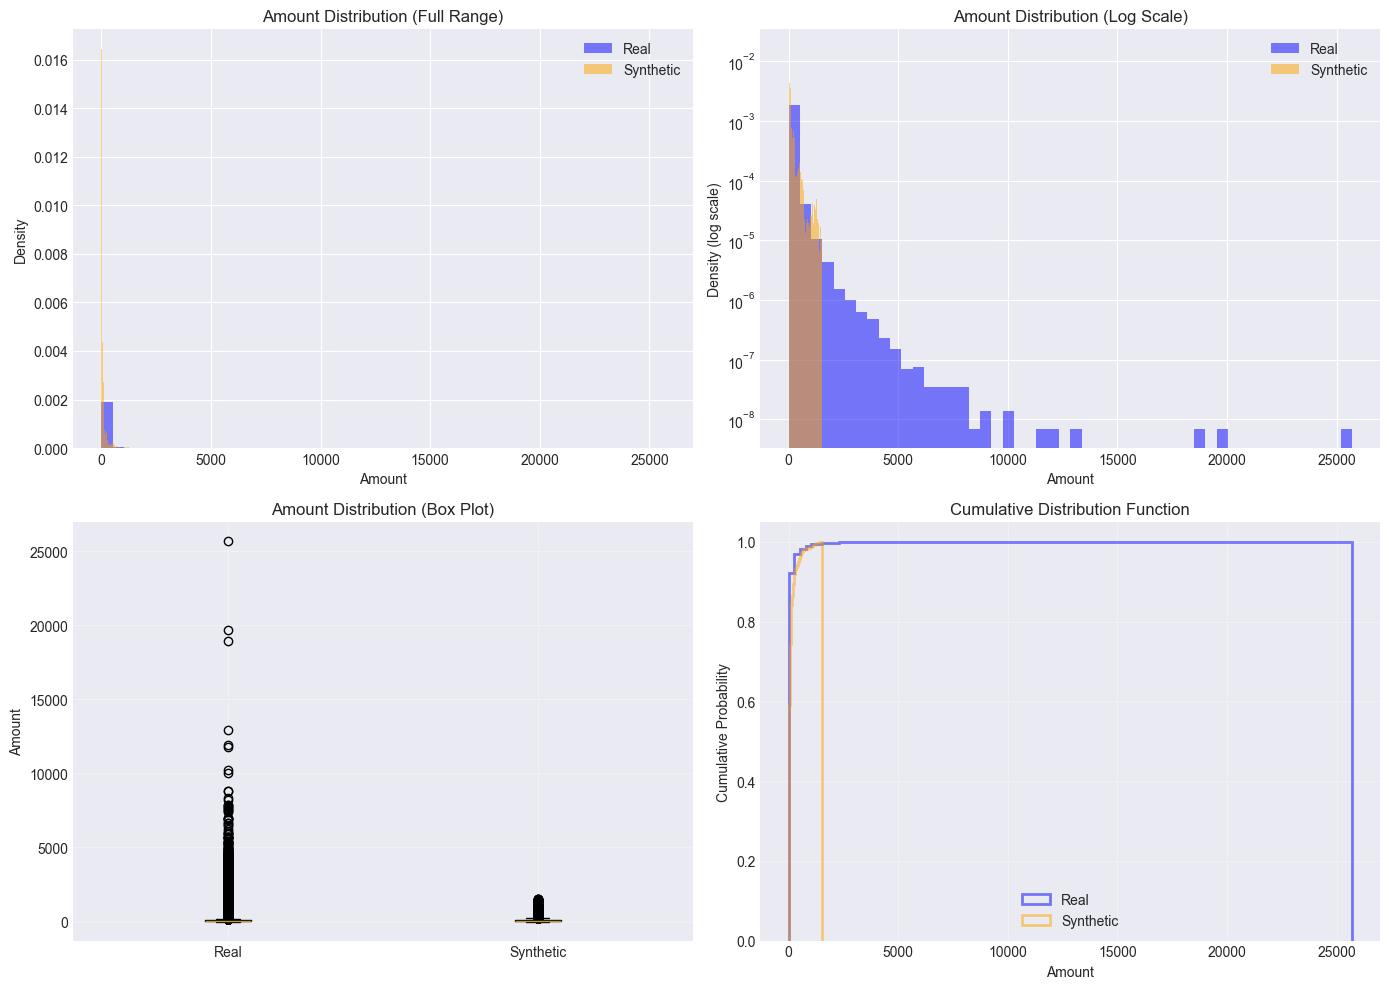


AMOUNT STATISTICS COMPARISON

Real:
count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

Synthetic:
count    10000.000000
mean        94.951008
std        186.019018
min          0.000000
25%          7.201885
50%         30.448628
75%         93.659602
max       1521.996812
Name: Amount, dtype: float64


In [12]:
# Amount comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram overlay
axes[0, 0].hist(df_real['Amount'], bins=50, alpha=0.5, label='Real', color='blue', density=True)
axes[0, 0].hist(df_synthetic['Amount'], bins=50, alpha=0.5, label='Synthetic', color='orange', density=True)
axes[0, 0].set_xlabel('Amount')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Amount Distribution (Full Range)')
axes[0, 0].legend()

# 2. Log-scale histogram (better for skewed data)
axes[0, 1].hist(df_real['Amount'], bins=50, alpha=0.5, label='Real', color='blue', density=True, log=True)
axes[0, 1].hist(df_synthetic['Amount'], bins=50, alpha=0.5, label='Synthetic', color='orange', density=True, log=True)
axes[0, 1].set_xlabel('Amount')
axes[0, 1].set_ylabel('Density (log scale)')
axes[0, 1].set_title('Amount Distribution (Log Scale)')
axes[0, 1].legend()

# 3. Box plots
data_to_plot = [df_real['Amount'], df_synthetic['Amount']]
axes[1, 0].boxplot(data_to_plot, labels=['Real', 'Synthetic'])
axes[1, 0].set_ylabel('Amount')
axes[1, 0].set_title('Amount Distribution (Box Plot)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Cumulative distribution
axes[1, 1].hist(df_real['Amount'], bins=100, alpha=0.5, label='Real', color='blue', 
                density=True, cumulative=True, histtype='step', linewidth=2)
axes[1, 1].hist(df_synthetic['Amount'], bins=100, alpha=0.5, label='Synthetic', color='orange', 
                density=True, cumulative=True, histtype='step', linewidth=2)
axes[1, 1].set_xlabel('Amount')
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].set_title('Cumulative Distribution Function')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Numerical comparison
print("\nAMOUNT STATISTICS COMPARISON")
print("\nReal:")
print(df_real['Amount'].describe())
print("\nSynthetic:")
print(df_synthetic['Amount'].describe())

## **8. Visual Check: Time Distribution**

Time shows cyclical patterns (day/night transaction volumes) — let's see if CTGAN captures this.

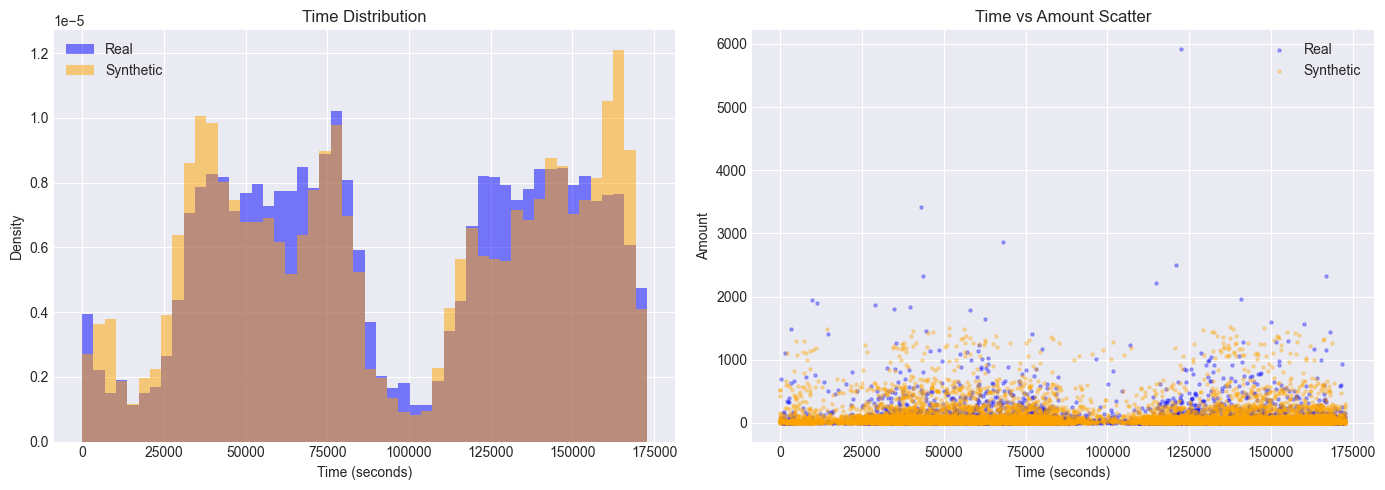


TIME STATISTICS COMPARISON

Real:
count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

Synthetic:
count     10000.000000
mean      94318.532218
std       50274.026503
min           0.000000
25%       48815.956552
50%       83681.987391
75%      142878.014289
max      172792.000000
Name: Time, dtype: float64


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Histogram overlay
axes[0].hist(df_real['Time'], bins=50, alpha=0.5, label='Real', color='blue', density=True)
axes[0].hist(df_synthetic['Time'], bins=50, alpha=0.5, label='Synthetic', color='orange', density=True)
axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Density')
axes[0].set_title('Time Distribution')
axes[0].legend()

# 2. Time series scatter (sample to avoid overplotting)
sample_size = min(5000, len(df_real))
real_sample = df_real.sample(sample_size)
axes[1].scatter(real_sample['Time'], real_sample['Amount'], alpha=0.3, s=5, label='Real', color='blue')
axes[1].scatter(df_synthetic['Time'], df_synthetic['Amount'], alpha=0.3, s=5, label='Synthetic', color='orange')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Amount')
axes[1].set_title('Time vs Amount Scatter')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nTIME STATISTICS COMPARISON")
print("\nReal:")
print(df_real['Time'].describe())
print("\nSynthetic:")
print(df_synthetic['Time'].describe())

## **9. Quick Check: Top V-Features**

From EDA, we know V3, V14, V17, V12, V10 are most discriminative for fraud.

Let's spot-check a few V-features.

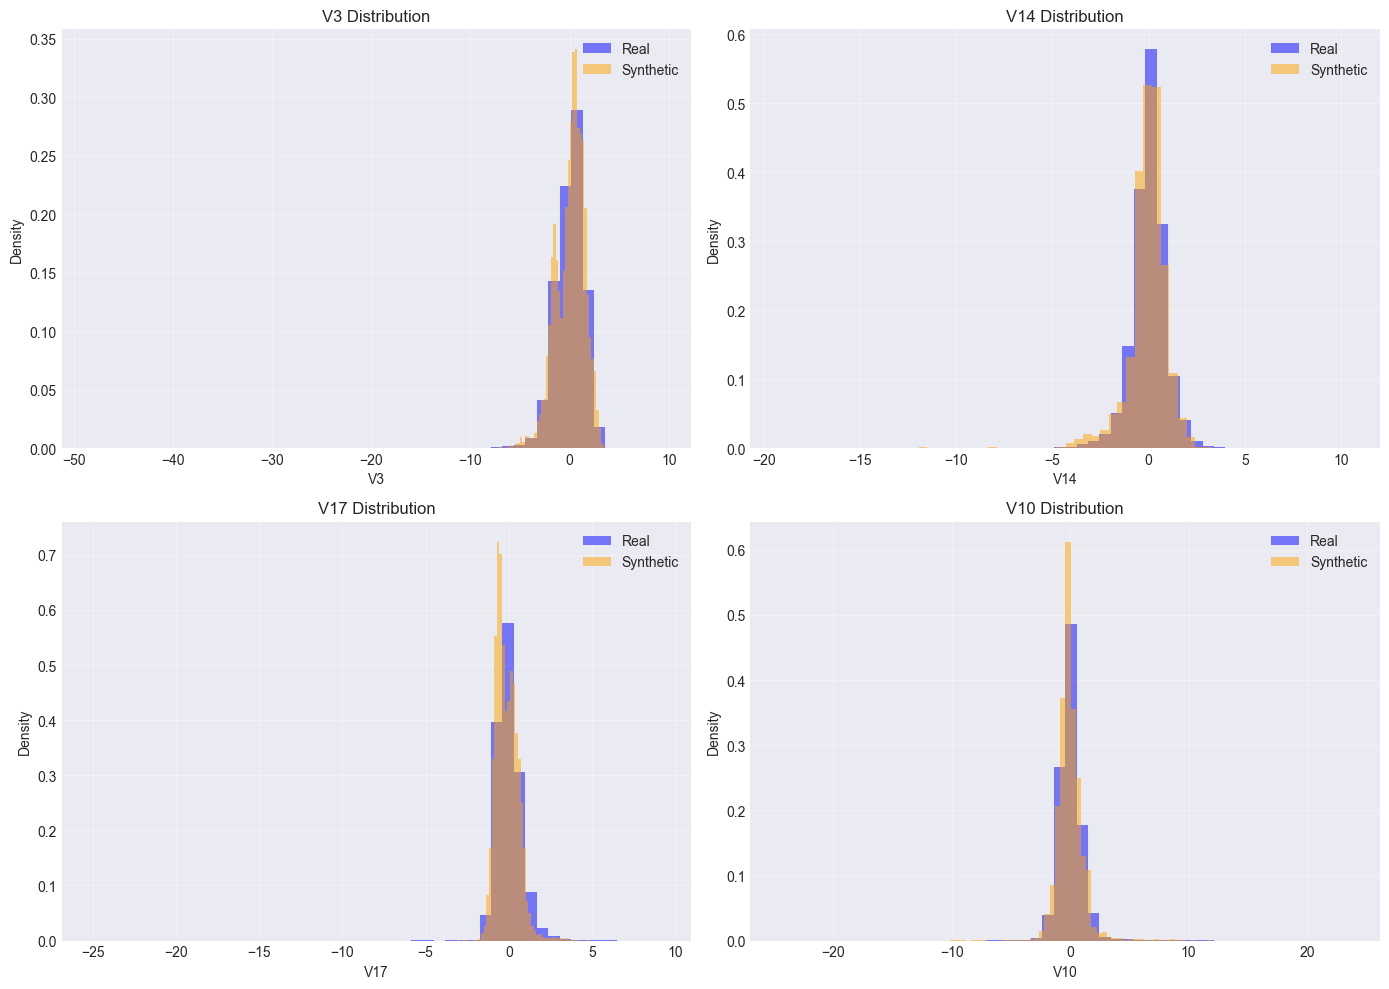

In [14]:
# Check top discriminative V-features
top_v_features = ['V3', 'V14', 'V17', 'V10']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(top_v_features):
    axes[i].hist(df_real[feature], bins=50, alpha=0.5, label='Real', color='blue', density=True)
    axes[i].hist(df_synthetic[feature], bins=50, alpha=0.5, label='Synthetic', color='orange', density=True)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'{feature} Distribution')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **10. Statistical Comparison: KS Tests**

Use **Kolmogorov-Smirnov tests** to quantify distribution similarity.

**KS Statistic interpretation:**
- 0.0 = identical distributions
- <0.05 = very similar
- 0.05-0.10 = somewhat similar
- >0.10 = different distributions

In [15]:
# Run KS tests for all numerical columns
numerical_cols = df_real.select_dtypes(include=[np.number]).columns

ks_results = []
for col in numerical_cols:
    ks_stat, p_value = ks_2samp(df_real[col], df_synthetic[col])
    ks_results.append({
        'Feature': col,
        'KS_Statistic': ks_stat,
        'P_Value': p_value,
        'Similar': 'Yes' if ks_stat < 0.05 else 'No'
    })

df_ks = pd.DataFrame(ks_results).sort_values('KS_Statistic', ascending=False)

print("\nKS TEST RESULTS (sorted by KS statistic)")
print("="*70)
print(df_ks.to_string(index=False))
print("\n" + "="*70)

# Summary
n_similar = (df_ks['KS_Statistic'] < 0.05).sum()
print(f"\nFeatures with KS < 0.05 (very similar): {n_similar}/{len(df_ks)}")
print(f"Features with KS >= 0.05 (need improvement): {len(df_ks) - n_similar}/{len(df_ks)}")


KS TEST RESULTS (sorted by KS statistic)
Feature  KS_Statistic       P_Value Similar
    V17      0.115848 2.049271e-113      No
    V27      0.115379 1.690169e-112      No
 Amount      0.097120  9.079787e-80      No
    V19      0.086539  2.132466e-63      No
    V18      0.078370  4.682840e-52      No
    V28      0.069254  9.818052e-41      No
    V22      0.064579  1.795670e-35      No
    V12      0.061331  4.930235e-32      No
    V13      0.057325  4.888902e-28      No
    V26      0.056326  4.402933e-27      No
     V2      0.055552  2.350126e-26      No
    V21      0.055432  3.043586e-26      No
     V9      0.051661  7.547979e-23      No
    V24      0.050683  5.234240e-22      No
    V15      0.049375  6.590077e-21     Yes
     V5      0.048243  5.592641e-20     Yes
     V7      0.045836  4.469056e-18     Yes
     V8      0.045744  5.259420e-18     Yes
    V11      0.043674  1.888195e-16     Yes
   Time      0.042669  1.011360e-15     Yes
     V4      0.041253  1.007070e-1

## **12. Save Synthetic Data (Optional)**

Save for later inspection if needed.

In [1]:
# Save final synthetic dataset for Week 2 baseline
output_dir = Path('../data/synthetic')
output_dir.mkdir(parents=True, exist_ok=True)

output_path = output_dir / 'week1_final_10k.csv'
df_synthetic.to_csv(output_path, index=False)

print(f"✓ Final synthetic dataset saved to {output_path}")
print(f"  - Rows: {len(df_synthetic):,}")
print(f"  - Fraud rate: {df_synthetic['Class'].mean():.4f}")
print(f"  - Columns: {df_synthetic.shape[1]}")

NameError: name 'Path' is not defined

In [2]:
# Save the trained CTGAN model
from pathlib import Path

model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

model_path = model_dir / 'ctgan_day4_150epochs.pkl'
synthesizer.save(model_path)

print(f"✓ Model saved to {model_path}")
print(f"  - Epochs trained: 150")
print(f"  - Training time: ~287 minutes")
print(f"  - Features with KS < 0.05: 17/31 (54.8%)")

NameError: name 'synthesizer' is not defined

In [ ]:
# Week 1 Final Summary
print("="*70)
print("WEEK 1 COMPLETE - FINAL RESULTS")
print("="*70)
print(f"\n✅ CTGAN Training Successful")
print(f"  - Model: Conditional CTGAN")
print(f"  - Epochs: 150")
print(f"  - Training time: 4.8 hours")
print(f"\n✅ Fraud Rate Preservation")
print(f"  - Target: 0.173%")
print(f"  - Achieved: {df_synthetic['Class'].mean()*100:.2f}%")
print(f"  - Match: PERFECT")
print(f"\n✅ Statistical Quality (KS < 0.05)")
print(f"  - Day 3: 3/31 features (9.7%)")
print(f"  - Day 4: 17/31 features (54.8%)")
print(f"  - Improvement: +467%")
print(f"\n✅ Best Performing Features:")
ks_best = df_ks.nsmallest(5, 'KS_Statistic')
for _, row in ks_best.iterrows():
    print(f"  - {row['Feature']}: KS = {row['KS_Statistic']:.4f}")
print(f"\n📁 Files Generated:")
print(f"  - Model: models/ctgan_day4_150epochs.pkl")
print(f"  - Dataset: data/synthetic/week1_final_10k.csv")
print(f"\n🎯 Next: Week 2-3 - Scale to 100K samples + validation pipeline")
print("="*70)